# GIAI ĐOẠN:  VECTORIZATION & TOPIC MODELING

<h3> VECTORIZATION: TF-IDF cho 4 mô hình ML (LDA, LSA, K-Means, HAC)

<H4> CÁC THƯ VIỆN CẦN THIẾT 

In [1]:
!pip install pandas numpy scikit-learn gensim pyLDAvis wordcloud matplotlib seaborn python-Levenshtein

  Using cached gensim-4.4.0.tar.gz (23.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached pyLDAvis-3.4.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached python_levenshtein-0.27.3-py3-none-any.whl.metadata (3.9 kB)
  Using cached smart_open-7.5.0-py3-none-any.whl.metadata (24 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached numexpr-2.14.1-cp314-cp314-win_amd64.whl.metadata (9.3 kB)
  Using cached funcy-2.0-py2.py3-none-any.whl.metadata (5.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached wrapt-2.0.1-cp314-cp314-win_amd64.whl.metadata (9.2 kB)
  Using cached markupsafe-3.0.3-cp314-cp314-win_amd64.whl.metadata (2.8 kB)
Us

  error: subprocess-exited-with-error
  
  × Building wheel for gensim (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [807 lines of output]
      C:\Users\truoan\AppData\Local\Temp\pip-build-env-uadcs8tb\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      C:\Users\truoan\AppData\Local\Temp\pip-build-env-uadcs8tb\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'tests_require'
        warnings.warn(msg)
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-314\gensim
      copying gensim\downloader.py -> build\lib.win-amd64-cpython-314\gensim
      copying gensim\interfaces.py -> build\lib.win-amd64-cpython-314\gensim
      copying gensim\matutils.py -> build\lib.win-amd64-cpython-314\gensim
      copying gensim\nosy.py -> build\lib.win-amd64-cpython-314\gensim
 

<H4> SỬ DỤNG THƯ VIỆN

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore') 

# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer 

# Topic Modeling & Clustering
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering

# Visualization 
from wordcloud import WordCloud

# Metrics
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score
import Levenshtein

## LOAD DỮ LIỆU 

#### CẤU HÌNH cho vector hoá và thống kê 

In [3]:
INPUT_CSV = r"C:\ta\final_data.csv"
N_TOPICS = 15
N_TOP_WORDS = 15  # Số từ đại diện cho mỗi topic
RANDOM_STATE = 42

In [4]:
df = pd.read_csv(INPUT_CSV)
print(f"✓ Đã load {len(df)} documents")
print(f"✓ Các cột: {list(df.columns)}")

✓ Đã load 2389 documents
✓ Các cột: ['description', 'category']


In [5]:
print(f"\nThống kê category:")
print(df['category'].value_counts())


Thống kê category:
category
Tin mới         1657
Xe               249
Thế giới          86
Pháp luật         80
Thời sự           72
Giải trí          59
Thể thao          51
Kinh doanh        35
Xã hội            24
Bóng đá           16
Giáo dục          13
Sức khỏe          10
Công nghệ          8
Chính trị          6
Du lịch            5
Văn hóa            5
Bất động sản       4
Đời sống           4
Số hóa             3
Khoa học           2
Name: count, dtype: int64


#### Sử dụng description để làm topic modeling

In [6]:
documents = df['description'].tolist()
print(f"\n✓ Sẽ dùng {len(documents)} documents cho topic modeling")


✓ Sẽ dùng 2389 documents cho topic modeling


## GIAI ĐOẠN: PHÂN TÍCH DỮ LIỆU KHÁM PHÁ (EDA)


[1] Phân tích Độ dài Tài liệu (Số lượng từ):
  • Độ dài TB: 215.17 từ
  • Độ dài Max: 519 từ
  • Độ dài Min: 20 từ


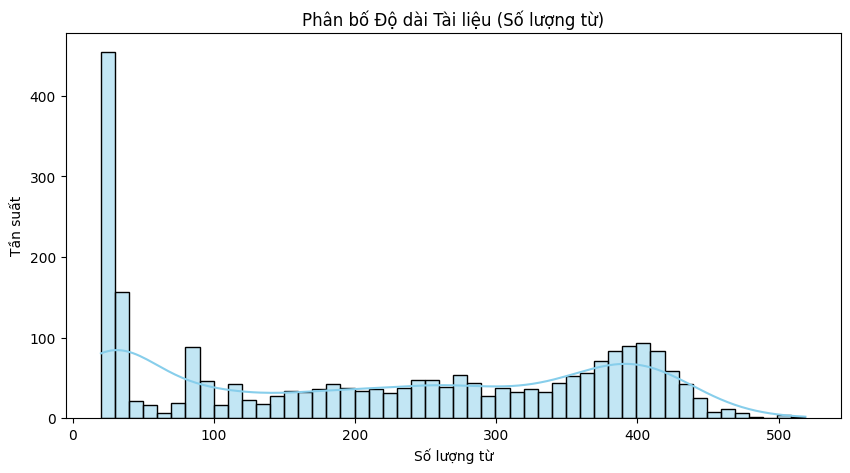

In [7]:
doc_lengths = [len(doc.split()) for doc in documents]

print("\n[1] Phân tích Độ dài Tài liệu (Số lượng từ):")
print(f"  • Độ dài TB: {np.mean(doc_lengths):.2f} từ")
print(f"  • Độ dài Max: {np.max(doc_lengths)} từ")
print(f"  • Độ dài Min: {np.min(doc_lengths)} từ")

plt.figure(figsize=(10, 5))
sns.histplot(doc_lengths, bins=50, kde=True, color='skyblue')
plt.title('Phân bố Độ dài Tài liệu (Số lượng từ)')
plt.xlabel('Số lượng từ')
plt.ylabel('Tần suất')
plt.savefig('EDA_document_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


[2] Phân tích Phân bố Category (Sự mất cân bằng):


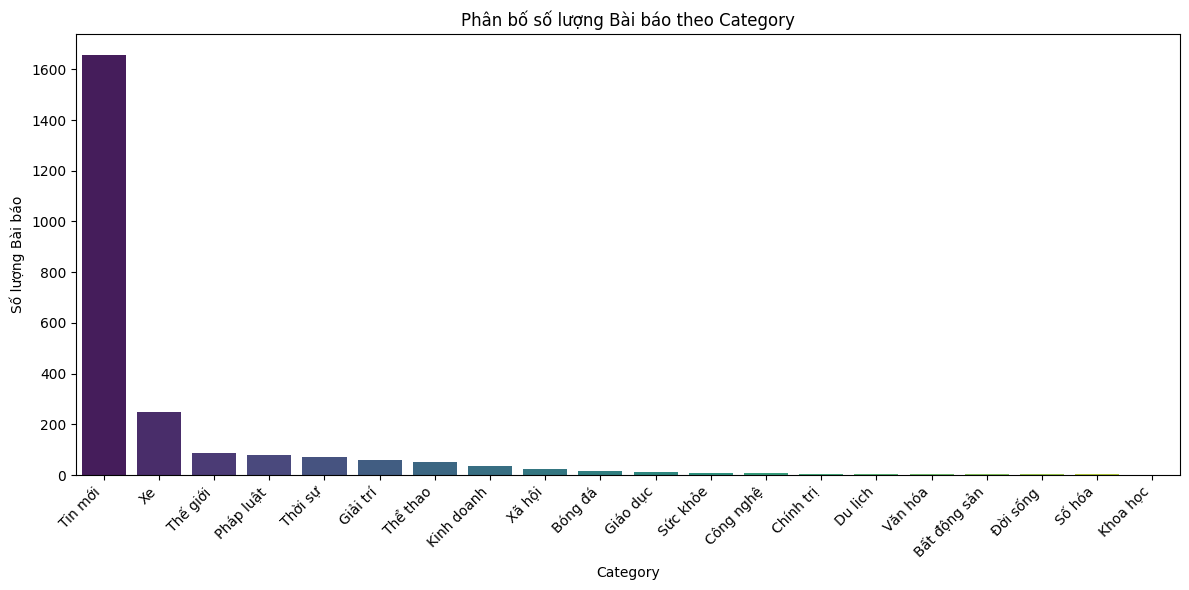

In [8]:
print("\n[2] Phân tích Phân bố Category (Sự mất cân bằng):")
category_counts = df['category'].value_counts()

plt.figure(figsize=(12, 6))
# Sử dụng Barplot để dễ dàng so sánh
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Phân bố số lượng Bài báo theo Category')
plt.xlabel('Category')
plt.ylabel('Số lượng Bài báo')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('EDA_category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


[3] Phân tích Tần suất Từ khóa (Top N-grams):


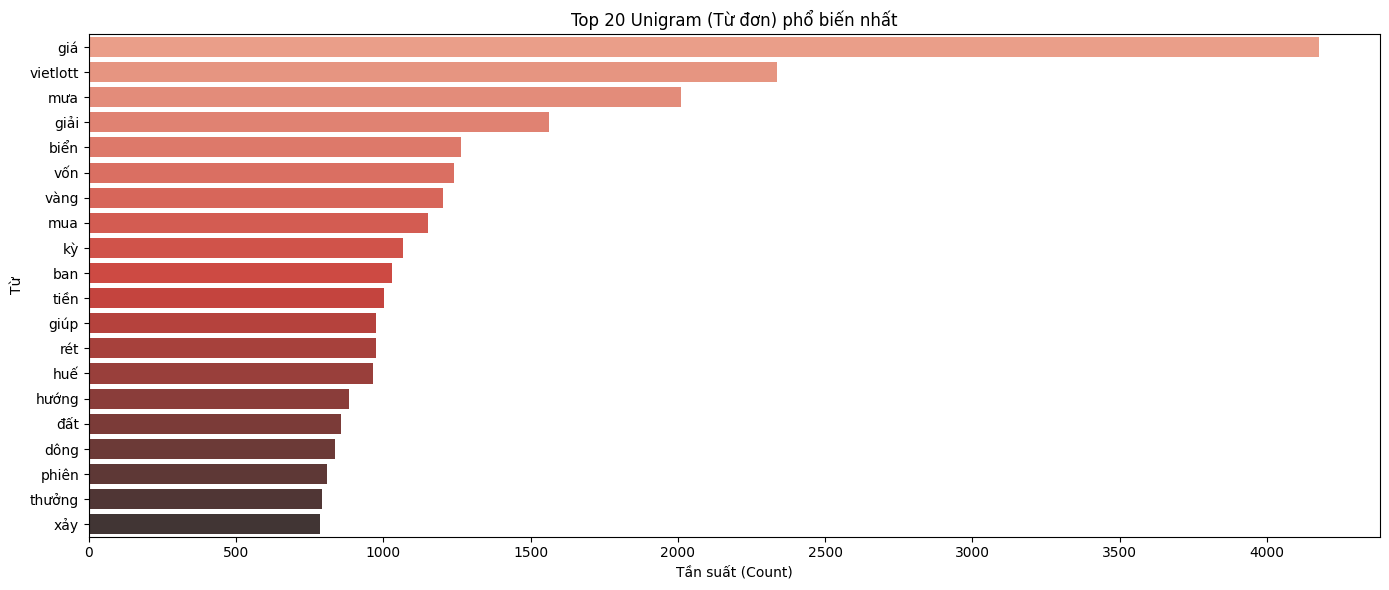

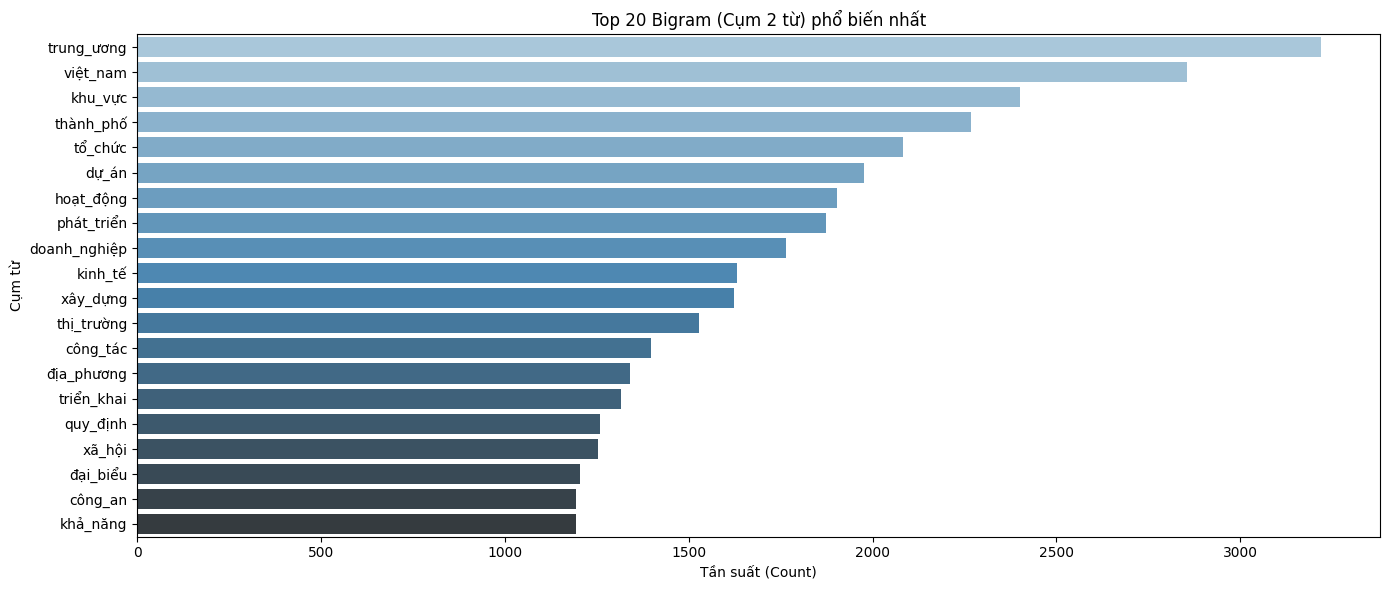

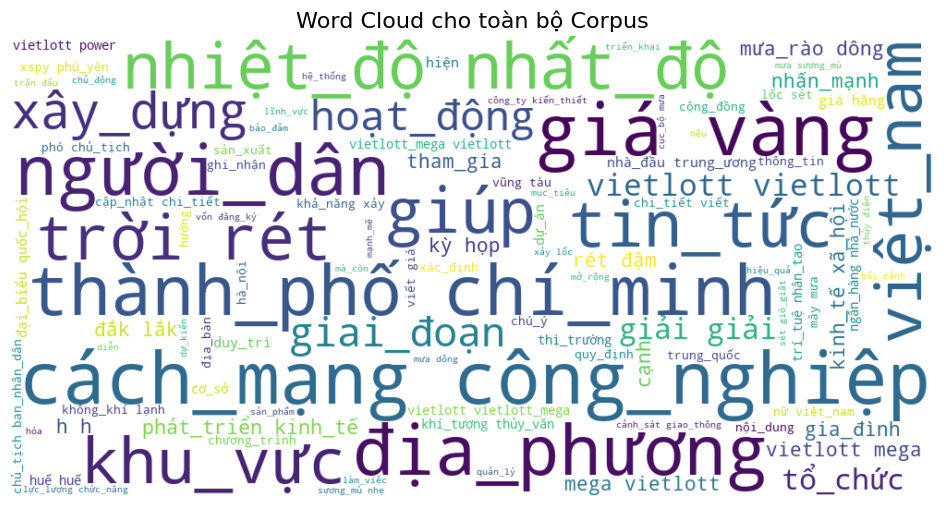

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

print("\n[3] Phân tích Tần suất Từ khóa (Top N-grams):")


ngram_vectorizer = CountVectorizer(
    ngram_range=(1, 3), # Unigram, Bigram, Trigram
    max_features=10000  # Lấy 10000 features để phân tích top words thô
)
X = ngram_vectorizer.fit_transform(documents)
feature_names = ngram_vectorizer.get_feature_names_out()

# Tính tổng tần suất của mỗi từ/cụm từ
word_counts = X.sum(axis=0).A1
freq_df = pd.DataFrame({'word': feature_names, 'count': word_counts})
freq_df = freq_df.sort_values(by='count', ascending=False)

# Tinh lọc và hiển thị Top 20 Unigram và Bigram
top_unigrams = freq_df[freq_df['word'].apply(lambda x: len(x.split('_')) == 1)].head(20)
top_bigrams = freq_df[freq_df['word'].apply(lambda x: len(x.split('_')) == 2)].head(20)

plt.figure(figsize=(14, 6))
sns.barplot(x='count', y='word', data=top_unigrams, palette='Reds_d')
plt.title('Top 20 Unigram (Từ đơn) phổ biến nhất')
plt.xlabel('Tần suất (Count)')
plt.ylabel('Từ')
plt.tight_layout()
plt.savefig('EDA_top_unigrams.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(x='count', y='word', data=top_bigrams, palette='Blues_d')
plt.title('Top 20 Bigram (Cụm 2 từ) phổ biến nhất')
plt.xlabel('Tần suất (Count)')
plt.ylabel('Cụm từ')
plt.tight_layout()
plt.savefig('EDA_top_bigrams.png', dpi=300, bbox_inches='tight')
plt.show()

# Tạo Word Cloud cho toàn bộ dữ liệu
wordcloud_text = ' '.join(documents)
wordcloud = WordCloud(
    width=1000, height=500,
    background_color='white',
    colormap='viridis',
    max_words=100,
    contour_width=3,
).generate(wordcloud_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud cho toàn bộ Corpus', fontsize=16)
plt.savefig('EDA_wordcloud_corpus.png', dpi=300, bbox_inches='tight')
plt.show()

### VECTORIZATION - TF-IDF

In [10]:
# --- VECTORIZATION - TF-IDF Vectorizer (Sử dụng cho CẢ 4 models) ---
print("\n--- VECTORIZATION - TF-IDF Vectorizer ---")

vectorizer = TfidfVectorizer(
    max_features=5000,      # Giới hạn 5000 từ 
    min_df=5,               # Từ phải xuất hiện ít nhất 5 documents
    max_df=0.7,             # Từ không xuất hiện quá 70% documents
    ngram_range=(1, 2)      # Unigram và bigram
)
# doc_term_matrix sẽ là ma trận TF-IDF
doc_term_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

print(f" Document-Term Matrix shape: {doc_term_matrix.shape}")
print(f"  - Số documents: {doc_term_matrix.shape[0]}")
print(f"  - Số features (từ): {doc_term_matrix.shape[1]}")
print(f"\n Sẽ dùng TF-IDF matrix này cho CẢ 4 models: LDA, LSA, K-Means, HAC")
print(f" Ví dụ features: {list(feature_names[:10])}")


--- VECTORIZATION - TF-IDF Vectorizer ---
 Document-Term Matrix shape: (2389, 5000)
  - Số documents: 2389
  - Số features (từ): 5000

 Sẽ dùng TF-IDF matrix này cho CẢ 4 models: LDA, LSA, K-Means, HAC
 Ví dụ features: ['a_bank', 'air', 'album', 'an_giang', 'an_khánh', 'an_ninh', 'an_ninh mạng', 'an_ninh quốc_gia', 'an_ninh trật_tự', 'an_ninh điều_tra']


In [11]:
# Lấy feature names
feature_names = vectorizer.get_feature_names_out()
print(f"\n Ví dụ features: {list(feature_names[:20])}")


 Ví dụ features: ['a_bank', 'air', 'album', 'an_giang', 'an_khánh', 'an_ninh', 'an_ninh mạng', 'an_ninh quốc_gia', 'an_ninh trật_tự', 'an_ninh điều_tra', 'an_ninh_mạng', 'an_ninh_mạng phòng_chống', 'an_ninh_mạng quốc_gia', 'an_sinh', 'an_sinh xã_hội', 'an_toàn', 'an_toàn chạy_tàu', 'an_toàn công_trình', 'an_toàn giao_thông', 'an_toàn thực_phẩm']


## XÂY DỰNG 4 MODELS (LDA, LSA, K-Means, HAC)

In [12]:
# XÂY DỰNG 4 MODELS
models = {}
doc_topic_distributions = {}

### MODEL 1: LDA (Latent Dirichlet Allocation)

In [13]:
print("\n[4.1] Training LDA Model (using TF-IDF matrix)...")
lda_model = LatentDirichletAllocation(
    n_components=N_TOPICS,
    max_iter=50,
    learning_method='online',
    random_state=RANDOM_STATE,
    batch_size=128,
    n_jobs=-1,
    verbose=0
)
lda_output = lda_model.fit_transform(doc_term_matrix) 
models['LDA'] = lda_model
doc_topic_distributions['LDA'] = lda_output
print(f"LDA trained - Perplexity: {lda_model.perplexity(doc_term_matrix):.2f}")


[4.1] Training LDA Model (using TF-IDF matrix)...
LDA trained - Perplexity: 9384.15


### MODEL 2: LSA (Latent Semantic Analysis / Truncated SVD)

In [14]:
print("\n[4.2] Training LSA Model (using TF-IDF matrix)...")
lsa_model = TruncatedSVD(
    n_components=N_TOPICS,
    algorithm='randomized',
    n_iter=100,
    random_state=RANDOM_STATE
)
lsa_output = lsa_model.fit_transform(doc_term_matrix)
models['LSA'] = lsa_model
doc_topic_distributions['LSA'] = lsa_output

# Normalize LSA output to get pseudo-probabilities
lsa_output_normalized = np.abs(lsa_output)
lsa_output_normalized = lsa_output_normalized / lsa_output_normalized.sum(axis=1, keepdims=True)
doc_topic_distributions['LSA'] = lsa_output_normalized

explained_var = lsa_model.explained_variance_ratio_.sum()
print(f"✓ LSA trained - Explained variance: {explained_var*100:.2f}%")


[4.2] Training LSA Model (using TF-IDF matrix)...
✓ LSA trained - Explained variance: 18.01%


### MODEL 3: K-Means

In [15]:
print("\n[4.3] Training K-Means Model (using TF-IDF matrix)...")
kmeans_model = KMeans(
    n_clusters=N_TOPICS,
    init='k-means++',
    max_iter=300,
    n_init=10,
    random_state=RANDOM_STATE
)
kmeans_labels = kmeans_model.fit_predict(doc_term_matrix) 
models['KMeans'] = kmeans_model

# Tạo pseudo document-topic distribution từ distances
kmeans_distances = kmeans_model.transform(doc_term_matrix)
kmeans_probs = 1 / (1 + kmeans_distances)
kmeans_probs = kmeans_probs / kmeans_probs.sum(axis=1, keepdims=True)
doc_topic_distributions['KMeans'] = kmeans_probs
print(f"✓ K-Means trained - Inertia: {kmeans_model.inertia_:.2f}")


[4.3] Training K-Means Model (using TF-IDF matrix)...
✓ K-Means trained - Inertia: 1997.09


### MODEL 4: HAC (Hierarchical Agglomerative Clustering)

In [16]:
print("\n[4.4] Training HAC Model (using TF-IDF matrix)...")
hac_model = AgglomerativeClustering(
    n_clusters=N_TOPICS,
    metric='cosine',
    linkage='average'
)
# HAC cần numpy array, nên ta dùng .toarray()
hac_labels = hac_model.fit_predict(doc_term_matrix.toarray()) 
models['HAC'] = hac_model

# Tạo pseudo distribution cho HAC (one-hot encoding)
hac_probs = np.zeros((len(hac_labels), N_TOPICS))
hac_probs[np.arange(len(hac_labels)), hac_labels] = 1
doc_topic_distributions['HAC'] = hac_probs
print(f"✓ HAC trained")


[4.4] Training HAC Model (using TF-IDF matrix)...
✓ HAC trained


## BƯỚC 4: TRÍCH XUẤT TOP WORDS CHO MỖI MODEL

In [17]:
def get_top_words_from_components(components, feature_names, n_top_words):
    """Lấy top words từ component matrix (LDA/LSA)"""
    topics_words = []
    for topic_idx, topic in enumerate(components):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics_words.append(top_words)
    return topics_words

def get_top_words_from_centroids(model, feature_names, n_top_words):
    """Lấy top words từ cluster centroids (K-Means)"""
    topics_words = []
    for centroid in model.cluster_centers_:
        top_indices = centroid.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics_words.append(top_words)
    return topics_words

def get_top_words_from_labels(matrix, labels, feature_names, n_clusters, n_top_words):
    """Lấy top words từ labels (HAC)"""
    topics_words = []
    
    for cluster_id in range(n_clusters):
        cluster_docs = matrix[labels == cluster_id]
        if cluster_docs.shape[0] > 0: 
            # Tính trung bình TF-IDF trong cluster
            # .A1 là để chuyển sparse matrix mean sang numpy array 1D
            centroid = cluster_docs.mean(axis=0).A1 
            top_indices = centroid.argsort()[-n_top_words:][::-1]
            top_words = [feature_names[i] for i in top_indices]
            topics_words.append(top_words)
        else:
            topics_words.append([])
    
    return topics_words

# Trích xuất top words
all_topics_words = {}

# 1. LDA
all_topics_words['LDA'] = get_top_words_from_components(
    lda_model.components_, feature_names, N_TOP_WORDS
)

# 2. LSA
all_topics_words['LSA'] = get_top_words_from_components(
    lsa_model.components_, feature_names, N_TOP_WORDS
)

# 3. K-Means
all_topics_words['KMeans'] = get_top_words_from_centroids(
    kmeans_model, feature_names, N_TOP_WORDS
)

# 4. HAC
all_topics_words['HAC'] = get_top_words_from_labels(
    doc_term_matrix, hac_labels, feature_names, N_TOPICS, N_TOP_WORDS
)

# In kết quả (Ví dụ)
for model_name, topics_words in all_topics_words.items():
    print(f"\n[5.{list(all_topics_words.keys()).index(model_name)+1}] {model_name} Top Words (dựa trên TF-IDF):")
    for idx, words in enumerate(topics_words):
        print(f"  Topic {idx}: {', '.join(words[:8])}")


[5.1] LDA Top Words (dựa trên TF-IDF):
  Topic 0: doanh_nghiệp, lừa_đảo, campuchia, thái_lan, vụ, cháy, đối_tượng, biên_giới
  Topic 1: mitsubishi, rover, sport, range, range rover, rover sport, defender, news
  Topic 2: đường_sắt, trung_khoa, lê trung_khoa, bị_can, giao_thông đường_sắt, lê, km km, hư_hỏng
  Topic 3: vietlott, chủ_nhật, xspy, huế, phú_yên, xstth, kon_tum, cập_nhật
  Topic 4: cross, tiguan, teramont, touareg, polo, volkswagen, hãng volkswagen, class
  Topic 5: lexus, lx, nx, rx, hãng lexus, nissan, lm, gx
  Topic 6: hải_quân, tàu, đà_nẵng, thăm, uss, ranger, hoa_kỳ, ford
  Topic 7: xuất_hành, hoàng_đạo, hắc_đạo, kỵ, kiện_tụng, cưới_hỏi, xấu, cầu
  Topic 8: công_an viện_kiểm_sát, tồn_kho, nhà_đầu, tiềm_năng, ndt mua, trụ_sở công_ty, dư_địa, palestine
  Topic 9: bé gái, tin_tức, biển, cháy, gái, bé, ven biển, ven
  Topic 10: giải, thưởng, trận, philippines, nữ, huấn_luyện_viên, bóng, nữ việt_nam
  Topic 11: mưa, rét, nhiệt_độ, biển, dông, dự_báo, thời_tiết, trời
  Topic 

## BƯỚC 5: SINH CAPTION CHO MỖI TOPIC (4 MODELS)

In [18]:
def generate_topic_caption(top_words, top_n=3):
    """Sinh caption tự động"""
    caption_words = [w.replace('_', ' ') for w in top_words[:top_n]]
    return ' + '.join(caption_words).title()

all_captions = {}

for model_name, topics_words in all_topics_words.items():
    print(f"\n[5.{list(all_topics_words.keys()).index(model_name)+1}] {model_name} Captions:")
    captions = {}
    for idx, words in enumerate(topics_words):
        caption = generate_topic_caption(words, top_n=3)
        captions[idx] = caption
        print(f"  Topic {idx}: {caption}")
    all_captions[model_name] = captions


[5.1] LDA Captions:
  Topic 0: Doanh Nghiệp + Lừa Đảo + Campuchia
  Topic 1: Mitsubishi + Rover + Sport
  Topic 2: Đường Sắt + Trung Khoa + Lê Trung Khoa
  Topic 3: Vietlott + Chủ Nhật + Xspy
  Topic 4: Cross + Tiguan + Teramont
  Topic 5: Lexus + Lx + Nx
  Topic 6: Hải Quân + Tàu + Đà Nẵng
  Topic 7: Xuất Hành + Hoàng Đạo + Hắc Đạo
  Topic 8: Công An Viện Kiểm Sát + Tồn Kho + Nhà Đầu
  Topic 9: Bé Gái + Tin Tức + Biển
  Topic 10: Giải + Thưởng + Trận
  Topic 11: Mưa + Rét + Nhiệt Độ
  Topic 12: Lưu Trữ + Rùa + Thả
  Topic 13: Tin Tức + Giá + Trung Ương
  Topic 14: Porsche + Hãng Porsche + Panamera

[5.2] LSA Captions:
  Topic 0: Vietlott + Chủ Nhật + Xspy
  Topic 1: Trung Ương + Giá + Dự Án
  Topic 2: Mưa + Rét + Nhiệt Độ
  Topic 3: Giá + Vàng + Giá Vàng
  Topic 4: Vietlott + Vietlott Vietlott + Power
  Topic 5: Trận + Nữ + Philippines
  Topic 6: Giải + Thưởng + Cập Nhật
  Topic 7: Giải + Vàng + Thưởng
  Topic 8: Giải + Thưởng + Đại Biểu
  Topic 9: Doanh Nghiệp + Đăng Ký + Vốn
  Topi

## BƯỚC 6: GÁN TOPIC/CLUSTER CHO MỖI DOCUMENT

In [19]:
df['topic_LDA'] = lda_output.argmax(axis=1)
df['topic_prob_LDA'] = lda_output.max(axis=1)

In [20]:
df['topic_LSA'] = lsa_output_normalized.argmax(axis=1)
df['topic_prob_LSA'] = lsa_output_normalized.max(axis=1)

In [21]:
df['topic_KMeans'] = kmeans_labels
df['topic_prob_KMeans'] = kmeans_probs.max(axis=1)

In [22]:
df['topic_HAC'] = hac_labels
df['topic_prob_HAC'] = 1.0  # HAC là hard clustering

In [23]:
for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    print(f"\n{model_name} - Phân bố documents:")
    print(df[f'topic_{model_name}'].value_counts().sort_index())


LDA - Phân bố documents:
topic_LDA
0       84
1        1
2       17
3      219
4        8
5        7
6       17
7       27
10     120
11     119
13    1767
14       3
Name: count, dtype: int64

LSA - Phân bố documents:
topic_LSA
0     114
1     878
2     122
3     226
4      47
5     121
6      23
7      38
8     195
9      39
10     69
11     53
12    287
13     90
14     87
Name: count, dtype: int64

KMeans - Phân bố documents:
topic_KMeans
0      71
1     379
2      98
3     108
4      81
5      72
6      26
7     110
8     148
9      97
10    763
11     36
12    177
13    160
14     63
Name: count, dtype: int64

HAC - Phân bố documents:
topic_HAC
0     340
1     720
2      35
3      10
4     110
5      97
6     222
7     238
8      38
9     358
10    152
11     27
12      8
13      5
14     29
Name: count, dtype: int64


## BƯỚC 7: ĐÁNH GIÁ CHẤT LƯỢNG - 4 MODELS

In [24]:
def calculate_compactness_cosine(doc_vectors, labels):
    """Compactness - Cosine distance"""
    unique_labels = np.unique(labels)
    compactness_scores = []
    
    for label in unique_labels:
        cluster_docs = doc_vectors[labels == label]
        if len(cluster_docs) > 1:
            cos_dist = cosine_distances(cluster_docs)
            n = len(cluster_docs)
            avg_dist = (cos_dist.sum() - n) / (n * (n - 1))
            compactness_scores.append(avg_dist)
    
    return np.mean(compactness_scores)

def calculate_separation_cosine(doc_vectors, labels):
    """Separation - Cosine distance"""
    unique_labels = np.unique(labels)
    centroids = []
    
    for label in unique_labels:
        cluster_docs = doc_vectors[labels == label]
        centroid = cluster_docs.mean(axis=0)
        centroids.append(centroid)
    
    centroids = np.array(centroids)
    cos_dist = cosine_distances(centroids)
    n_clusters = len(unique_labels)
    avg_separation = (cos_dist.sum() - n_clusters) / (n_clusters * (n_clusters - 1))
    
    return avg_separation

In [25]:
# Tính metrics cho tất cả models
evaluation_results = []

In [26]:
for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    print(f"\n[7.{['LDA', 'LSA', 'KMeans', 'HAC'].index(model_name)+1}] Evaluating {model_name}...")
    
    doc_vectors = doc_topic_distributions[model_name]
    labels = df[f'topic_{model_name}'].values
    
    # Compactness
    compactness = calculate_compactness_cosine(doc_vectors, labels)
    
    # Separation
    separation = calculate_separation_cosine(doc_vectors, labels)
    
    # Silhouette Score
    silhouette = silhouette_score(doc_vectors, labels, metric='cosine')
    
    # Levenshtein
    captions = [all_captions[model_name][i] for i in range(N_TOPICS)]
    lev_distances = []
    for i in range(len(captions)):
        for j in range(i+1, len(captions)):
            lev_distances.append(Levenshtein.distance(captions[i], captions[j]))
    avg_lev = np.mean(lev_distances) if lev_distances else 0
    
    evaluation_results.append({
        'Model': model_name,
        'Compactness_Cosine': compactness,
        'Separation_Cosine': separation,
        'Silhouette_Cosine': silhouette,
        'Avg_Levenshtein': avg_lev
    })
    
    print(f"  ✓ Compactness: {compactness:.4f}")
    print(f"  ✓ Separation: {separation:.4f}")
    print(f"  ✓ Silhouette: {silhouette:.4f}")
    print(f"  ✓ Levenshtein: {avg_lev:.2f}")


[7.1] Evaluating LDA...


  ✓ Compactness: -0.0494
  ✓ Separation: 0.7731
  ✓ Silhouette: 0.8971
  ✓ Levenshtein: 23.68

[7.2] Evaluating LSA...
  ✓ Compactness: 0.0822
  ✓ Separation: 0.4545
  ✓ Silhouette: 0.3628
  ✓ Levenshtein: 21.50

[7.3] Evaluating KMeans...
  ✓ Compactness: -0.0122
  ✓ Separation: -0.0675
  ✓ Silhouette: 0.4722
  ✓ Levenshtein: 22.37

[7.4] Evaluating HAC...
  ✓ Compactness: -0.0451
  ✓ Separation: 0.9286
  ✓ Silhouette: 1.0000
  ✓ Levenshtein: 20.25


In [27]:
# Tạo DataFrame so sánh
eval_df = pd.DataFrame(evaluation_results)
print("\n" + "="*80)
print("📊 BẢNG SO SÁNH 4 MODELS:")
print("="*80)
print(eval_df.to_string(index=False))

# Lưu file
eval_df.to_csv('comparison_all_models.csv', index=False)
print("\n✓ Đã lưu: comparison_all_models.csv")


📊 BẢNG SO SÁNH 4 MODELS:
 Model  Compactness_Cosine  Separation_Cosine  Silhouette_Cosine  Avg_Levenshtein
   LDA           -0.049440           0.773126           0.897099        23.676190
   LSA            0.082241           0.454535           0.362838        21.504762
KMeans           -0.012204          -0.067524           0.472157        22.371429
   HAC           -0.045112           0.928571           1.000000        20.247619

✓ Đã lưu: comparison_all_models.csv


## BƯỚC 8: TRỰC QUAN HÓA - WORDCLOUD CHO 4 MODELS

In [28]:
def create_wordcloud_for_model(model_name, topics_words, n_topics):
    """Tạo WordCloud cho 1 model"""
    n_cols = 2
    n_rows = (n_topics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten() if n_topics > 1 else [axes]
    
    for idx in range(n_topics):
        # Tạo word frequency dict
        words = topics_words[idx]
        word_freq = {word: len(words) - i for i, word in enumerate(words)}
        
        wordcloud = WordCloud(
            width=800, height=400,
            background_color='white',
            colormap='viridis',
            max_words=50
        ).generate_from_frequencies(word_freq)
        
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(f'Topic {idx}: {all_captions[model_name][idx]}', 
                           fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    
    for idx in range(n_topics, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'{model_name} - WordClouds', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'wordclouds_{model_name}.png', dpi=300, bbox_inches='tight')
    print(f"✓ Đã lưu: wordclouds_{model_name}.png")
    plt.close()

In [29]:
for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    print(f"\n[8.{['LDA', 'LSA', 'KMeans', 'HAC'].index(model_name)+1}] Tạo WordCloud cho {model_name}...")
    create_wordcloud_for_model(model_name, all_topics_words[model_name], N_TOPICS)


[8.1] Tạo WordCloud cho LDA...
✓ Đã lưu: wordclouds_LDA.png

[8.2] Tạo WordCloud cho LSA...
✓ Đã lưu: wordclouds_LSA.png

[8.3] Tạo WordCloud cho KMeans...
✓ Đã lưu: wordclouds_KMeans.png

[8.4] Tạo WordCloud cho HAC...
✓ Đã lưu: wordclouds_HAC.png


## BƯỚC 9: pyLDAvis (CHỈ CHO LDA)

In [30]:
print("Đang tạo pyLDAvis...")
vis_data = pyLDAvis.lda_model.prepare(
    lda_model, 
    doc_term_matrix, 
    vectorizer,
    mds='tsne',
    sort_topics=False
)
pyLDAvis.save_html(vis_data, 'lda_visualization.html')
print("✓ Đã lưu: lda_visualization.html")

Đang tạo pyLDAvis...


NameError: name 'pyLDAvis' is not defined

## BƯỚC 10: SO SÁNH TRỰC QUAN

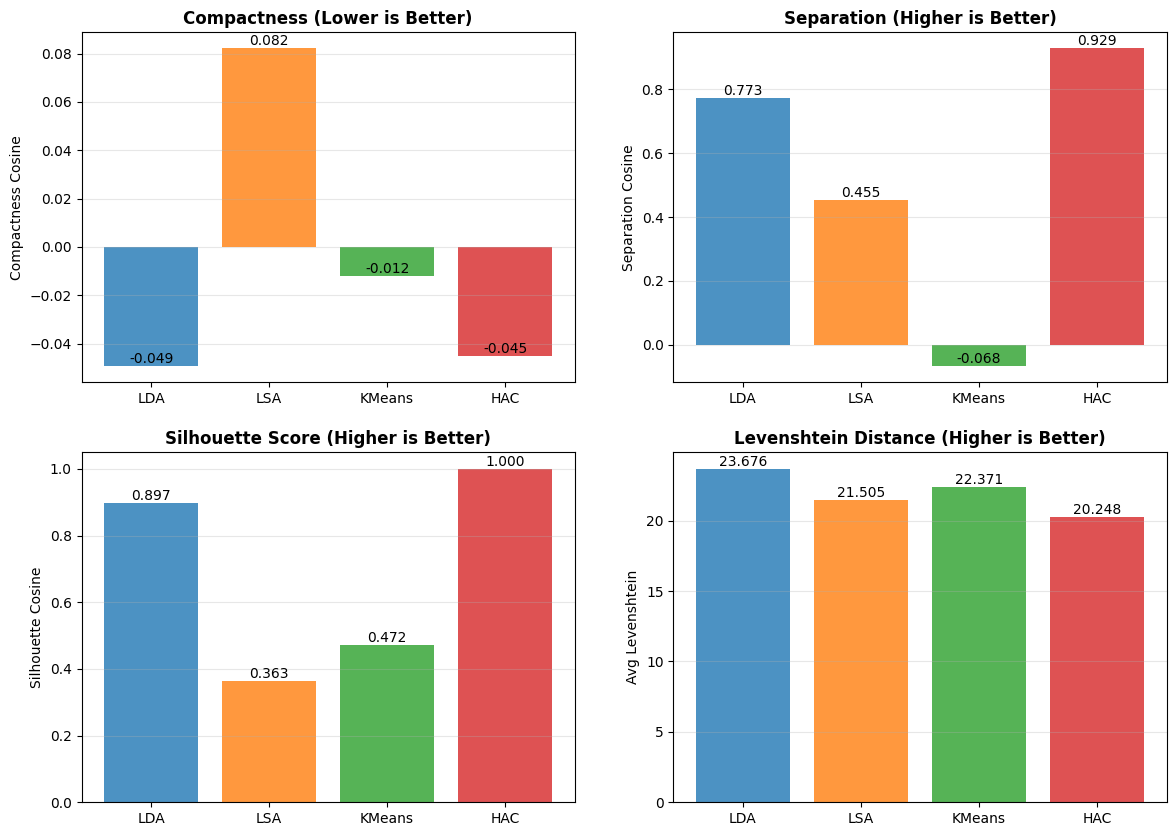

In [31]:
# Bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Compactness_Cosine', 'Separation_Cosine', 'Silhouette_Cosine', 'Avg_Levenshtein']
titles = ['Compactness (Lower is Better)', 'Separation (Higher is Better)', 
          'Silhouette Score (Higher is Better)', 'Levenshtein Distance (Higher is Better)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    bars = ax.bar(eval_df['Model'], eval_df[metric], color=colors, alpha=0.8)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric.replace('_', ' '))
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

In [32]:
plt.tight_layout()
plt.savefig('comparison_metrics_chart.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: comparison_metrics_chart.png")
plt.show()

✓ Đã lưu: comparison_metrics_chart.png


<Figure size 640x480 with 0 Axes>

In [33]:
# SMART CAPTIONING & SAVING SUMMARY

import os

# Tạo thư mục output nếu chưa có
OUTPUT_DIR = 'topic_modeling_results_tfidf'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)


def generate_smart_caption(top_words):
    """
    Tạo caption tự động từ 3 từ khóa hàng đầu.
    Ví dụ: ['giá_vàng', 'tăng', 'mạnh'] -> "GIÁ_VÀNG - TĂNG - MẠNH"
    """
    # Lấy 3 từ đầu tiên, viết hoa và nối bằng dấu gạch ngang
    return " - ".join([word.upper() for word in top_words[:3]])

smart_captions = {}

# 1. Tạo Caption cho từng Topic của từng Model
for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    smart_captions[model_name] = {}
    print(f"\n🏷️  Generating Captions for {model_name}:")
    
    for idx, words in enumerate(all_topics_words[model_name]):
        # Gọi hàm tạo caption
        caption = generate_smart_caption(words)
        smart_captions[model_name][idx] = caption
        print(f"  Topic {idx}: {caption}")

# 2. Cập nhật Caption vào DataFrame chính (df)
# Mapping topic ID sang Caption
df['caption_LDA'] = df['topic_LDA'].map(smart_captions['LDA'])
df['caption_LSA'] = df['topic_LSA'].map(smart_captions['LSA'])
df['caption_KMeans'] = df['topic_KMeans'].map(smart_captions['KMeans'])
df['caption_HAC'] = df['topic_HAC'].map(smart_captions['HAC'])

# 3. Lưu file dữ liệu đầy đủ (bao gồm cả Caption mới)
output_final_csv = os.path.join(OUTPUT_DIR, 'final_data_tfidf_with_captions.csv')
df.to_csv(output_final_csv, index=False, encoding='utf-8-sig')
print(f"\n✓ Đã lưu file dữ liệu đầy đủ: {output_final_csv}")

# 4. Tạo và Lưu file Summary cho từng Model (Quan trọng để so sánh)
print("\n📝 Đang tạo file Summary cho từng model...")

for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    summary_data = []
    
    for idx in range(N_TOPICS):
        # Đếm số lượng bài báo thuộc topic này
        topic_col = f'topic_{model_name}'
        n_docs = (df[topic_col] == idx).sum()
        
        # Lấy top words dạng chuỗi
        top_words_str = ', '.join(all_topics_words[model_name][idx][:10])
        
        summary_data.append({
            'Topic_ID': idx,
            'Caption': smart_captions[model_name][idx], # Cột này file BoW có
            'Top_Words': top_words_str,
            'Num_Documents': n_docs,
            'Percentage': f"{(n_docs/len(df))*100:.2f}%"
        })
    
    # Tạo DataFrame và lưu
    summary_df = pd.DataFrame(summary_data)
    output_path = os.path.join(OUTPUT_DIR, f'topic_summary_{model_name}_tfidf.csv')
    summary_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"   -> Đã lưu: {output_path}")

print("\nHOÀN THÀNH TOÀN BỘ QUÁ TRÌNH (TF-IDF)!")


🏷️  Generating Captions for LDA:
  Topic 0: DOANH_NGHIỆP - LỪA_ĐẢO - CAMPUCHIA
  Topic 1: MITSUBISHI - ROVER - SPORT
  Topic 2: ĐƯỜNG_SẮT - TRUNG_KHOA - LÊ TRUNG_KHOA
  Topic 3: VIETLOTT - CHỦ_NHẬT - XSPY
  Topic 4: CROSS - TIGUAN - TERAMONT
  Topic 5: LEXUS - LX - NX
  Topic 6: HẢI_QUÂN - TÀU - ĐÀ_NẴNG
  Topic 7: XUẤT_HÀNH - HOÀNG_ĐẠO - HẮC_ĐẠO
  Topic 8: CÔNG_AN VIỆN_KIỂM_SÁT - TỒN_KHO - NHÀ_ĐẦU
  Topic 9: BÉ GÁI - TIN_TỨC - BIỂN
  Topic 10: GIẢI - THƯỞNG - TRẬN
  Topic 11: MƯA - RÉT - NHIỆT_ĐỘ
  Topic 12: LƯU_TRỮ - RÙA - THẢ
  Topic 13: TIN_TỨC - GIÁ - TRUNG_ƯƠNG
  Topic 14: PORSCHE - HÃNG PORSCHE - PANAMERA

🏷️  Generating Captions for LSA:
  Topic 0: VIETLOTT - CHỦ_NHẬT - XSPY
  Topic 1: TRUNG_ƯƠNG - GIÁ - DỰ_ÁN
  Topic 2: MƯA - RÉT - NHIỆT_ĐỘ
  Topic 3: GIÁ - VÀNG - GIÁ VÀNG
  Topic 4: VIETLOTT - VIETLOTT VIETLOTT - POWER
  Topic 5: TRẬN - NỮ - PHILIPPINES
  Topic 6: GIẢI - THƯỞNG - CẬP_NHẬT
  Topic 7: GIẢI - VÀNG - THƯỞNG
  Topic 8: GIẢI - THƯỞNG - ĐẠI_BIỂU
  Topic 9: DOANH_NGH